In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent)

('2017-08-23',)


Text(0, 0.5, 'Precipitation (inches)')

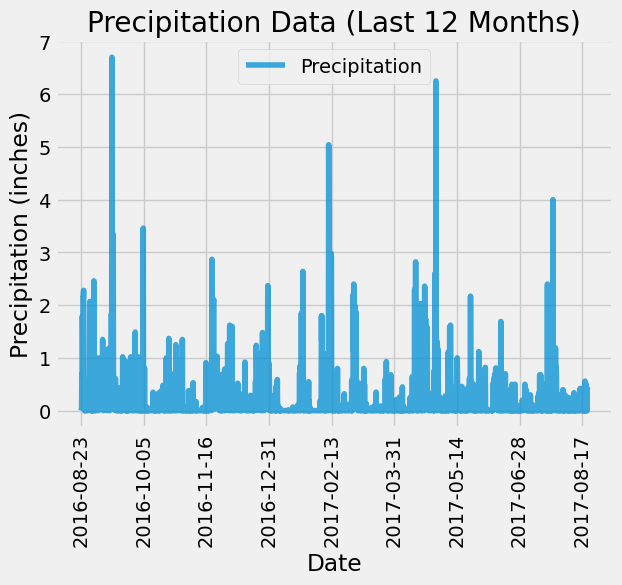

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# Change the recent date into the format we want
recent_date = dt.datetime.strptime(recent[0], '%Y-%m-%d')
# Subtract one from the recent date's year to find last year
prior_year = dt.date(recent_date.year - 1, recent_date.month, recent_date.day)
prior_year

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
result = session.query(*sel).filter(Measurement.date >= prior_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(result, columns = ["Date", "Precipitation"])

# Drop null values
precip_df = precip_df.dropna(how = "any")

# Sort the dataframe by date
precip_df = precip_df.sort_values(["Date"], ascending = True)
precip_df = precip_df.set_index("Date")
precip_df
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot = 90, alpha=0.75)
plt.title("Precipitation Data (Last 12 Months)")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.id).count()

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station, func.count(Measurement.id)]
stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
data = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
data

(54.0, 85.0, 71.66378066378067)

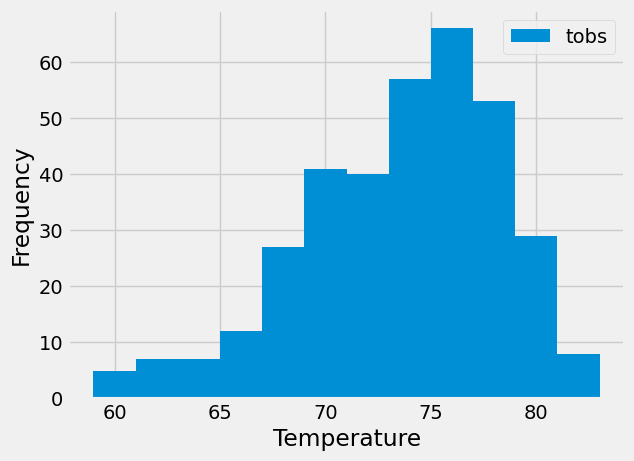

In [32]:
# Using the most active station id 
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result = session.query(Measurement.tobs).\
    filter(Measurement.station == stations[0][0]).\
    filter(Measurement.date >= prior_year).all()
# Send the temperatures to a list using the following website as reference:
# Numpy.ravel#. numpy.ravel - NumPy v1.25 Manual. (n.d.). https://numpy.org/doc/stable/reference/generated/numpy.ravel.html 
temperatures = list(np.ravel(result))

# Plot the histogram
plt.hist(temperatures, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"], loc="upper right")

# Close Session

In [17]:
# Close Session
session.close()